In [1]:
#basic imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 8,4
import warnings
warnings.filterwarnings('ignore')

#import statiscial models api
import statsmodels.api as sm

In [2]:
# Simple One Factor Linear Regression

mba_df = pd.read_csv('MBA Salary.csv')

In [3]:
mba_df.head()

,S. No.,Percentage in Grade 10,Salary
0,1,62.00,270000
1,2,76.33,200000
2,3,72.00,240000
3,4,60.00,250000
4,5,61.00,180000


In [4]:
#Lets add a 1.0 constant term to the salary dataset so we can estimate intercept value of linear reg. equation
X = sm.add_constant(mba_df["Percentage in Grade 10"])
X.head()

,const,Percentage in Grade 10
0,1.0,62.00
1,1.0,76.33
2,1.0,72.00
3,1.0,60.00
4,1.0,61.00


In [5]:
Y = mba_df['Salary']
Y.head()

0    270000
1    200000
2    240000
3    250000
4    180000
Name: Salary, dtype: int64

In [6]:
# Lets split the data
from sklearn.model_selection import train_test_split

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=0.8, random_state=100)

In [8]:
#Now, lets fit the model

mba_salary_lm = sm.OLS(train_Y, train_X).fit()


In [9]:
print(mba_salary_lm.params)

const                     30587.285652
Percentage in Grade 10     3560.587383
dtype: float64


<Figure size 576x432 with 0 Axes>

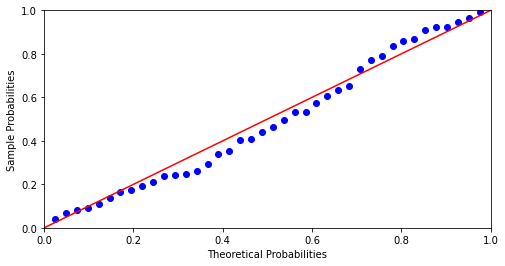

In [19]:
# Now, lets diagnose the model
mba_df_resid = mba_salary_lm.resid

probplot = sm.ProbPlot(mba_df_resid, fit=True)

plt.figure(figsize=(8, 6))
probplot.ppplot(line='45')
plt.show()

Text(0, 0.5, 'Standardized Residual Values')

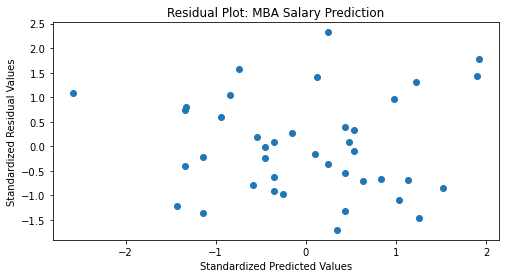

In [21]:
#WE can conclude the CDF of residuals is pretty close to CDF of normal dist. SO assumption is valid
#Now, lets check for homoscedasticity

#first, lets create a func for standardized values
def get_standardized_values(vals):
    return (vals-vals.mean())/(vals.std())

#Now lets plot stand. values of residuals vs stand. values of fitted values

plt.scatter(get_standardized_values(mba_salary_lm.fittedvalues), get_standardized_values(mba_df_resid))
plt.title("Residual Plot: MBA Salary Prediction")
plt.xlabel('Standardized Predicted Values')
plt.ylabel('Standardized Residual Values')

In [22]:
#Since above plot is random and not in a funnel shape, we can conclude residual variance is constant and hence homoscedasticity is maintained


In [27]:
#Outlier Analysis

#1 Z-Score
from scipy.stats import zscore
mba_df['zscore_salary'] = zscore(mba_df.Salary)

#Z score of more than 3 is considered outlier
mba_df[(mba_df.zscore_salary > 3.0) | (mba_df.zscore_salary < -3.0)]

,S. No.,Percentage in Grade 10,Salary,z score salary,zscore_salary


In [28]:
# No values of more than 3 so no outliers
#Look at Cooks Distance from book

In [31]:
#Now lets predict values

pred_Y = mba_salary_lm.predict(test_X)

In [32]:
#Now lets find error in pred
#Findinf Root Mean Squared Error RMSE

from sklearn.metrics import r2_score, mean_squared_error
np.abs(r2_score(test_Y, pred_Y))

0.156645849742304

In [33]:
# Lets calc the root mean square error
np.sqrt(mean_squared_error(test_Y, pred_Y))

73458.04348346895

In [38]:
# Lets instead calculate prediction intervals with confidence levels -
from statsmodels.sandbox.regression.predstd import wls_prediction_std

err, pred_Y_low, pred_Y_high = wls_prediction_std(mba_salary_lm, exog=test_X, alpha=0.1)

#Store values in dataframe

pred_Y_df = pd.DataFrame({'grade_10_perc': test_X['Percentage in Grade 10'], 'pred_Y':pred_Y, 'pred_Y_left':pred_Y_low,\
                          'pred_Y_right':pred_Y_high})
pred_Y_df.head()

,grade_10_perc,pred_Y,pred_Y_left,pred_Y_right
6,70.0,279828.402452,158379.832044,401276.972860
36,68.0,272707.227686,151576.715020,393837.740352
37,52.0,215737.829560,92950.942395,338524.716726
28,58.0,237101.353858,115806.869618,358395.838097
43,74.5,295851.045675,173266.083342,418436.008008


In [39]:
err

array([72035.49885795, 71846.84741458, 72829.30248119, 71944.10482994,
       72709.53362778, 71741.81781609, 72310.46293586, 73467.60789736,
       71678.26566477, 72690.84742484])